# Contamination plot
Notebook that generates figure 7 from the paper.

### Load python libraries and data

In [1]:
%pylab inline
import numpy as np
import tqdm
import scipy as sp
import scipy.constants as spc
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.stats import norm
from matplotlib import rc
rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from time import time as wall_time
import seaborn as sns
import matplotlib.colors
import pickle

plt.rc("font", family="serif")
plt.rc("text", usetex=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data files

# CNN predictions
saved_predictions = np.load("BNN_3D_predictions_test_h0_175_final_transform_4Mpc.npz")
M_true = saved_predictions["ground_truth"]
M_pred = saved_predictions["prediction"]

# Clusters
clusters = np.loadtxt("clusters_M200c_SAG_v3.0_4Mpch")
cluster_IDs = clusters[:, 0]
m_true = clusters[:, 1]

testIDs = np.load("clusters_ID_test_final_R=4.npz")["testIDs"]
testIDs += 1

# Pickle files with contamination
with open("new_r4_distance_interlopers_mass.pickle", 'rb') as p1:
    interloper_mass = pickle.load(p1)

with open("new_r4_distance_interlopers_PSdistance.pickle", 'rb') as p2:
    interloper_distance = pickle.load(p2)


### Process the pickle files
For each cluster, generate an array with the mass fraction of interlopers and one with the phase-space distance between the closest interloper cluster and the original cluster.

In [3]:
# mass fraction (non-logarithmic)
mass = []
# phase-space distance
distance = []

for i in range(len(interloper_mass)):
    # masses
    if interloper_mass[i] == 0:
        mass.append(0.0)
    else:
        real_masses = 10**(np.array(interloper_mass[i]))
        mass.append(sum(real_masses) / 10**(m_true[i]))

    # phase-space distances
    if np.any(np.isnan(interloper_distance[i])):
        distance.append(np.nan)
    else:
        distance.append(min(interloper_distance[i]))


### Get contamination arrays for the test set

In [4]:
distance_test = np.array([distance[i] for i in range(len(distance)) if cluster_IDs[i] in testIDs])
mass_test = np.array([mass[i] for i in range(len(mass)) if cluster_IDs[i] in testIDs])

print("Check if the array has the same length as M_true and M_pred.")
print("Len M_true:        ", len(M_true))
print("Len M_pred:        ", len(M_pred))
print("Len distance_test: ", len(distance_test))
print("Len mass_test:     ", len(mass_test))

Check if the array has the same length as M_true and M_pred.
Len M_true:         20633
Len M_pred:         20633
Len distance_test:  20633
Len mass_test:      20633


### Make the figure
Scatter plot of the clusters, where colour corresponds to the interloper mass ratio, and size to the phase-space distance between the original cluster and interloper cluster.

Text(0.5, 1.0, 'Interloper contamination in clusters')

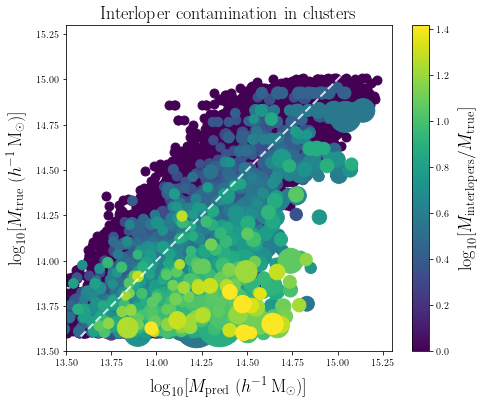

In [5]:
figure(figsize = (7.3,6))

# Order the arrays on the interloper mass ratio (low to high)
ordered_indices_mass = np.argsort(mass_test)
ordered_metric = mass_test[ordered_indices_mass]
ordered_metric2 = np.log10(ordered_metric + 1)
ordered_M_true = M_true[ordered_indices_mass]
ordered_M_pred = M_pred[ordered_indices_mass]
ordered_distance = distance_test[ordered_indices_mass]
# Size for scatter points (arbitrary scaling for right visibility)
size2 = (1/ordered_distance + 0.2) * 250

# Plot
scatter(M_pred, M_true, color="#440154FF", s=80)
im = scatter(ordered_M_pred, ordered_M_true, c=ordered_metric2, s=size2, cmap='viridis', vmin=0, vmax=np.log10(26)) #vmin=0, vmax=np.log10(20)); # vmin=0, vmax=20
plot([13.25,15.5], [13.25,15.5], linewidth=2, linestyle='--', color='white', alpha=0.8);
cbar = plt.colorbar(im)
cbar.set_label(r'$\textrm{log}_{10}[M_{\rm{interlopers}}  /  M_{\rm{true}}]$', labelpad=10, fontsize=18)

xlabel(r'$\log_{10}[M_{\mathrm{pred}} \; (h^{-1} \, \textrm{M}_{\odot})]$', fontsize=18, labelpad=10);
ylabel(r'$\log_{10}[M_{\mathrm{true}} \; (h^{-1} \, \textrm{M}_{\odot})]$', fontsize=18, labelpad=10);

xlim(13.5, 15.3);
ylim(13.5, 15.3);
plt.title("Interloper contamination in clusters", fontsize=18)

#savefig("Figure7_contamination.png", dpi=300, bbox_inches = "tight")


### Binned plots of the mass ratio and phase-space distance

In [6]:
def mass_binning(M200_true, M200_pred, mass_ratio, Nbins):
    
    epsilon = []
    std = []

    bins = np.linspace(0, 20, num=Nbins, endpoint=True)
    bin_centers = 0.5*(bins[0:bins.size-1] + bins[1:])
    
    for k in tqdm.tqdm(range(bins.size - 1)):
        temp_epsilon = []
        for i in range(M200_true.size):
            if mass_ratio[i] >= bins[k] and mass_ratio[i] <= bins[k+1]:
                temp_epsilon.append(np.abs(M200_pred[i] - M200_true[i]))
        epsilon.append(np.average(temp_epsilon))
        std.append(np.std(temp_epsilon))
    
    return np.array(epsilon), np.array(std), bin_centers

def distance_binning(M200_true, M200_pred, PSdistance, Nbins):
    
    epsilon = []
    std = []
    
    # Make arrays without Nans
    M200_true = M200_true[np.isnan(PSdistance) == False]
    M200_pred = M200_pred[np.isnan(PSdistance) == False]
    PSdistance = PSdistance[np.isnan(PSdistance) == False]

    bins = np.linspace(0, max(PSdistance), num=Nbins, endpoint=True)
    bin_centers = 0.5*(bins[0:bins.size-1] + bins[1:])
    
    for k in tqdm.tqdm(range(bins.size - 1)):
        temp_epsilon = []
        for i in range(M200_true.size):
            if PSdistance[i] >= bins[k] and PSdistance[i] <= bins[k+1]:
                temp_epsilon.append(np.abs(M200_pred[i] - M200_true[i]))
        epsilon.append(np.average(temp_epsilon))
        std.append(np.std(temp_epsilon))
    
    return np.array(epsilon), np.array(std), bin_centers


100%|██████████| 8/8 [00:00<00:00, 795.32it/s]


Text(0.5, 1.0, 'Phase-space distance')

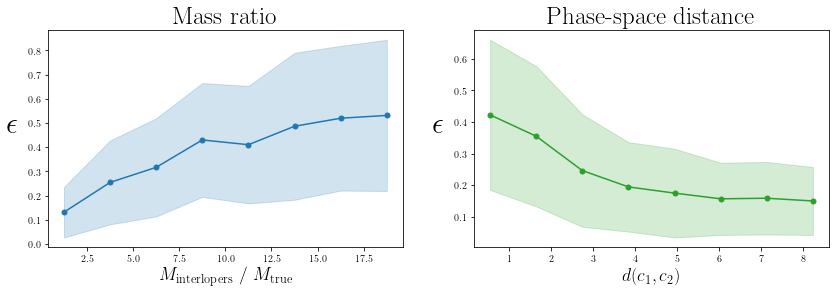

In [7]:
epsilon_mass, std_mass, bins_mass = mass_binning(M_true, M_pred, mass_test, Nbins=9)
epsilon_distance, std_distance, bins_distance = distance_binning(M_true, M_pred, distance_test, Nbins=9)

fig, ax = plt.subplots(1, 2, figsize=(14,4))
fig.subplots_adjust(hspace=0.2)
ax[0].plot(bins_mass, epsilon_mass, '.', ms=10)
ax[0].plot(bins_mass, epsilon_mass, color="C0")
ax[0].set_xlabel(r"$M_{\rm{interlopers}} \ / \ M_{\rm{true}}$", fontsize=18)
ax[0].set_ylabel(r"$\epsilon$", rotation=0, fontsize=30, labelpad=15)
ax[0].fill_between(bins_mass, epsilon_mass + std_mass, epsilon_mass - std_mass, color="C0", alpha=0.2)
ax[0].set_title("Mass ratio", fontsize=25)

ax[1].plot(bins_distance, epsilon_distance, '.', ms=10, color="C2")
ax[1].plot(bins_distance, epsilon_distance, color="C2")
ax[1].set_xlabel(r"$d(c_1, c_2)$", fontsize=18)
ax[1].set_ylabel(r"$\epsilon$", rotation=0, fontsize=30, labelpad=15)
ax[1].fill_between(bins_distance, epsilon_distance + std_distance, epsilon_distance - std_distance, color="C2", alpha=0.2)
ax[1].set_title("Phase-space distance", fontsize=25)

#savefig("Binned_mass_distance_contamination.png", dpi=300, bbox_inches = "tight")

These plots do not appear in the paper, but they show the general trend of increasing redisual scatter with interloper mass ratio, and decreasing residual scatter with distance between the two clusters.